In [ ]:
!pip install lightgbm scikit-learn pandas matplotlib


In [ ]:
# Core
import pandas as pd
import numpy as np
import re

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Resampling
!pip install -q imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
file_path = "/content/drive/MyDrive/Bootcamp_ML_Data_Science/Capstone_Project/model_with_out_source_data/data_extraction/merged_shuffled_20250822_185836.csv"
target_col = "Label"

df_head = pd.read_csv(file_path, nrows=5000)
print("Sample shape:", df_head.shape)
df_head.head()


Sample shape: (5000, 255)


/tmp/ipython-input-4083051376.py:4: DtypeWarning: Columns (45,62,65,118,119,136,138,142,143,145,166,197,203,204,205,215,218,219,247,248,250) have mixed types. Specify dtype option on import or set low_memory=False.
  df_head = pd.read_csv(file_path, nrows=5000)


,frame.encap_type,frame.len,frame.number,frame.time,frame.time_delta,frame.time_delta_displayed,frame.time_epoch,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,...,tls.compress_certificate.compressed_certificate_message.length,tls.connection_id,tls.handshake.extension.type,tls.handshake.extensions_key_share_group,tls.handshake.session_ticket_length,tls.handshake.version,tls.record.content_type,tls.record.version,Label,source_file
0,23,1292,1742836,Dec 18- 2020 19:18:52.264979000 GTB Standard Time,0.000253,0.000253,1608311932,580.225719,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,(Re)AssocTrue.csv
1,23,1610,2214767,Dec 15- 2020 22:47:52.363035000 EET,0.000001,0.000001,1608065272,580.511003,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,SSHTrue.csv
2,23,1550,2210848,Dec 15- 2020 22:47:51.992498000 EET,0.000901,0.000901,1608065272,580.140466,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,23,0x00000303,Normal,SSHTrue.csv
3,23,170,2538791,Dec 15- 2020 21:37:12.210892000 EET,0.000381,0.000381,1608061032,604.057814,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,Website_spoofingTrue.csv
4,23,88,2163111,Dec 15- 2020 15:29:48.475690000 GTB Standard Time,0.000002,0.000002,1608038988,595.571855,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,MalwareTrue.csv


In [ ]:
cols = df_head.columns.tolist()
assert target_col in cols, "Label column not found!"

# allow only 802.11 / radiotap / frame fields
allow_prefixes = ("frame.", "radiotap.", "wlan.", "wlan_radio.")

# hard blacklist
block_exact = set([
    "frame.number","frame.time","frame.time_epoch",
    "radiotap.mactime","radiotap.present.tsft","radiotap.timestamp.ts",
    "wlan.bssid","wlan.da","wlan.ra","wlan.sa","wlan.ta","wlan.ssid","wlan.tag","wlan.tag.length",
    "wlan.analysis.kck","wlan.analysis.kek","wlan.rsn.ie.gtk.key","wlan.rsn.ie.igtk.key","wlan.rsn.ie.pmkid",
    "wlan.fixed.timestamp","wlan_rsna_eapol.keydes.msgnr","wlan_rsna_eapol.keydes.data",
    "wlan_rsna_eapol.keydes.data_len","wlan_rsna_eapol.keydes.key_info.key_mic","wlan_rsna_eapol.keydes.nonce",
])

# regex blacklist
block_patterns = [
    r"(?i)\b(bssid|ssid|mac|addr|oui|vendor|station|ra|ta|sa|da)\b",
    r"(?i)^(ip\.|ipv6\.|arp|tcp\.|udp\.|dns|http|json|ssh|tls|smb2?|nbns|nbss|ldap|dhcp|mdns|ssdp)\b",
    r"(?i)(payload|data\.data|llc|eapol|key|nonce|pmkid|gtk|igtk|kck|kek)",
    r"(?i)(pcap|source_file|capture|interface)",
    r"(?i)(start_tsf|end_tsf|timestamp)",
]

def allowed(col: str) -> bool:
    if col == target_col:
        return True
    low = col.lower()
    if not low.startswith(allow_prefixes):
        return False
    if col in block_exact:
        return False
    for pat in block_patterns:
        if re.search(pat, low):
            return False
    return True

keep_cols = [c for c in cols if allowed(c)]
if target_col not in keep_cols:
    keep_cols.append(target_col)

print("Columns before:", len(cols), "| after filtering:", len(keep_cols))
print("First 15 kept:", keep_cols[:15])

# load filtered dataset
df = pd.read_csv(file_path, usecols=keep_cols)
df.replace("?", np.nan, inplace=True)

print("Filtered dataset shape:", df.shape)
df.head(3)


Columns before: 255 | after filtering: 39
First 15 kept: ['frame.encap_type', 'frame.len', 'frame.time_delta', 'frame.time_delta_displayed', 'frame.time_relative', 'radiotap.channel.flags.cck', 'radiotap.channel.flags.ofdm', 'radiotap.channel.freq', 'radiotap.datarate', 'radiotap.dbm_antsignal', 'radiotap.length', 'radiotap.rxflags', 'radiotap.vendor_oui', 'wlan.duration', 'wlan.country_info.fnm']


/tmp/ipython-input-3134114246.py:47: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=keep_cols)


Filtered dataset shape: (578678, 39)


,frame.encap_type,frame.len,frame.time_delta,frame.time_delta_displayed,frame.time_relative,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,...,wlan.fixed.reason_code,wlan_radio.duration,wlan.seq,wlan_radio.channel,wlan_radio.data_rate,wlan_radio.frequency,wlan_radio.signal_dbm,wlan_radio.phy,wlan.rsn.capabilities.mfpc,Label
0,23,1292,0.000253,0.000253,580.225719,0,1,5180,NaN,-113,...,NaN,103,2972.0,36,156.000,5180,-36,8,NaN,Normal
1,23,1610,0.000001,0.000001,580.511003,0,1,5180,NaN,-103,...,NaN,111,840.0,36,173.333,5180,-33,8,NaN,Normal
2,23,1550,0.000901,0.000901,580.140466,0,1,5180,NaN,-103,...,NaN,239,2604.0,36,58.500,5180,-33,8,NaN,Normal


Dataset shape after filtering attacks: (69710, 39)
Unique classes: ['SSDP' 'Evil_Twin' 'Krack' 'Deauth' '(Re)Assoc' 'RogueAP']


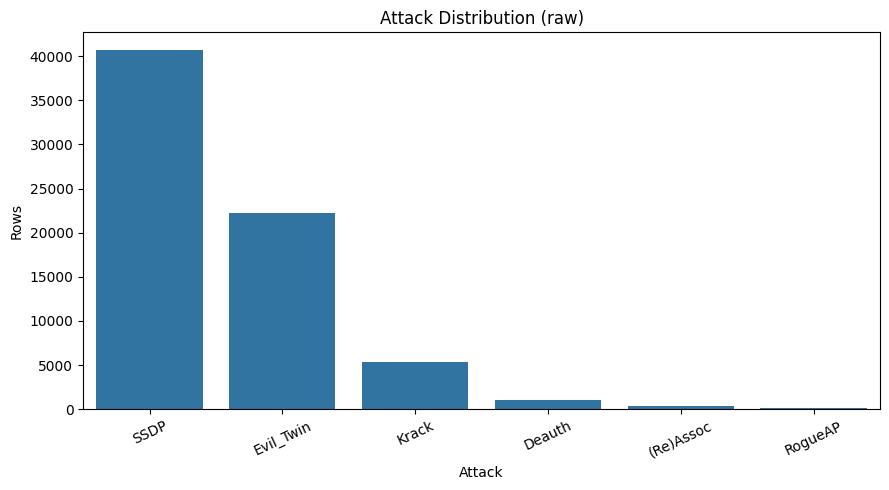

Counts:
 Label
SSDP         40665
Evil_Twin    22201
Krack         5327
Deauth        1011
(Re)Assoc      389
RogueAP        117
Name: count, dtype: int64


In [ ]:
REALTIME_ATTACKS = ["SSDP", "Evil_Twin", "Krack", "Deauth", "RogueAP", "(Re)Assoc"]
df = df[df[target_col].isin(REALTIME_ATTACKS)].reset_index(drop=True)

print("Dataset shape after filtering attacks:", df.shape)
print("Unique classes:", df[target_col].unique())

# Bar plot of counts
attack_counts = df[target_col].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x=attack_counts.index, y=attack_counts.values)
plt.title("Attack Distribution (raw)")
plt.xlabel("Attack")
plt.ylabel("Rows")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

print("Counts:\n", attack_counts)


In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (55768, 38) | Test: (13942, 38)


In [ ]:
def coerce_mixed_columns(df_train, df_test, hex_ok=True, thresh=0.8):
    df_train = df_train.copy()
    df_test  = df_test.copy()
    num_cols, cat_cols = [], []

    for c in df_train.columns:
        s_tr, s_te = df_train[c], df_test[c]
        if s_tr.dtype == object or str(s_tr.dtype).startswith("string"):
            st_tr = s_tr.astype(str)
            st_tr_num = pd.to_numeric(
                st_tr.str.replace(r"^\s*0x", "", regex=True), errors="coerce"
            ) if hex_ok else pd.to_numeric(st_tr, errors="coerce")

            if st_tr_num.notna().mean() >= thresh:
                st_te = s_te.astype(str)
                st_te_num = pd.to_numeric(
                    st_te.str.replace(r"^\s*0x", "", regex=True), errors="coerce"
                )
                df_train[c] = st_tr_num.astype("float32")
                df_test[c]  = st_te_num.astype("float32")
                num_cols.append(c)
            else:
                df_train[c] = st_tr.astype("string")
                df_test[c]  = s_te.astype("string")
                cat_cols.append(c)
        else:
            num_cols.append(c)

    return df_train, df_test, num_cols, cat_cols

X_train, X_test, num_cols, cat_cols = coerce_mixed_columns(X_train, X_test, hex_ok=True, thresh=0.8)
print(f"After coercion → numeric: {len(num_cols)} | categorical: {len(cat_cols)}")


After coercion → numeric: 36 | categorical: 2


In [ ]:
# Cast categorical to object (avoid pandas.NA problems)
if len(cat_cols):
    X_train[cat_cols] = X_train[cat_cols].astype("object")
    X_test[cat_cols]  = X_test[cat_cols].astype("object")

# Replace pandas.NA with np.nan for sklearn
X_train = X_train.replace({pd.NA: np.nan})
X_test  = X_test.replace({pd.NA: np.nan})

# Drop columns that are entirely NaN in train or test
na_cols_train = X_train.columns[X_train.isna().all()]
na_cols_test  = X_test.columns[X_test.isna().all()]
drop_cols = list(set(na_cols_train) | set(na_cols_test))

if drop_cols:
    print("Dropping all-NaN columns:", drop_cols)
    X_train.drop(columns=drop_cols, inplace=True)
    X_test.drop(columns=drop_cols, inplace=True)
    num_cols = [c for c in num_cols if c not in drop_cols]
    cat_cols = [c for c in cat_cols if c not in drop_cols]

print("Ready → numeric:", len(num_cols), "| categorical:", len(cat_cols))


Dropping all-NaN columns: ['radiotap.vendor_oui', 'wlan.fcs.bad_checksum']
Ready → numeric: 34 | categorical: 2


In [ ]:
# Strong keepers (behavioral + PHY)
keep_strong = [
    "wlan.seq","frame.time_relative","radiotap.dbm_antsignal","frame.time_delta",
    "wlan_radio.duration","wlan_radio.signal_dbm","frame.len","wlan_radio.data_rate",
    "wlan.duration","radiotap.datarate","wlan.fc.subtype","wlan.fc.retry",
    "frame.time_delta_displayed","wlan.fixed.beacon","wlan.fc.protected",
    # optional mids if present
    "radiotap.channel.freq","wlan_radio.phy"
]

# Very weak/noisy to drop
drop_weak = {
    "wlan.fixed.reason_code","wlan.fixed.capabilities.ess","wlan.fixed.capabilities.ibss",
    "wlan.rsn.capabilities.mfpc","radiotap.rxflags","radiotap.channel.flags.cck",
    "radiotap.channel.flags.ofdm","radiotap.length","frame.encap_type","wlan_radio.frequency",
    "wlan.fc.pwrmgt","wlan.fc.moredata","wlan.fc.frag","wlan.fc.order",
    "wlan.country_info.fnm","wlan.country_info.code"
}

available = set(X_train.columns) | set(X_test.columns)

# final keep list = (strong ∩ available) + (others not explicitly dropped)
keep_cols_final = [c for c in keep_strong if c in available]
keep_cols_final += [c for c in X_train.columns if (c not in drop_weak and c not in keep_cols_final)]

to_drop = [c for c in X_train.columns if c not in keep_cols_final]
print(f"Keeping {len(keep_cols_final)} columns; dropping {len(to_drop)} columns.")
print("Kept (first 15):", keep_cols_final[:15])

X_train = X_train[keep_cols_final].copy()
X_test  = X_test[keep_cols_final].copy()

# Update num/cat lists post-prune
num_cols = [c for c in num_cols if c in keep_cols_final]
cat_cols = [c for c in cat_cols if c in keep_cols_final]


Keeping 20 columns; dropping 16 columns.
Kept (first 15): ['wlan.seq', 'frame.time_relative', 'radiotap.dbm_antsignal', 'frame.time_delta', 'wlan_radio.duration', 'wlan_radio.signal_dbm', 'frame.len', 'wlan_radio.data_rate', 'wlan.duration', 'radiotap.datarate', 'wlan.fc.subtype', 'wlan.fc.retry', 'frame.time_delta_displayed', 'wlan.fixed.beacon', 'wlan.fc.protected']


In [ ]:
num_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordenc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

prep = ColumnTransformer(
    [("num", num_tf, num_cols)] + ([("cat", cat_tf, cat_cols)] if cat_cols else []),
    remainder="drop"
)

prep.fit(X_train)
X_train_t = prep.transform(X_train)
X_test_t  = prep.transform(X_test)

print("✅ Preprocessing complete!")
print("Transformed shapes:", X_train_t.shape, X_test_t.shape)


✅ Preprocessing complete!
Transformed shapes: (55768, 20) (13942, 20)


In [ ]:
# If not already installed earlier:
# !pip install -q imbalanced-learn

import numpy as np
import pandas as pd
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

TARGET_PER_CLASS = 15_000
MAJORS = {"SSDP": TARGET_PER_CLASS, "Evil_Twin": TARGET_PER_CLASS}

print("Before resampling:\n", y_train.value_counts())

# 1) Downsample majority classes to 15k
rus = RandomUnderSampler(sampling_strategy=MAJORS, random_state=42)
X_under, y_under = rus.fit_resample(X_train_t, y_train)

# 2) Build SMOTE sampling plan: number of synthetic samples to add per class
counts = Counter(y_under)
smote_plan = {}
for cls, n in counts.items():
    if n < TARGET_PER_CLASS:
        smote_plan[cls] = TARGET_PER_CLASS - n  # number of samples to synthesize for this class

# Safety: if nothing to oversample (already balanced), skip SMOTE
if smote_plan:
    # Choose k_neighbors safely for the smallest class
    min_class_size = min(counts[c] for c in smote_plan.keys())
    k_neighbors = max(1, min(5, min_class_size - 1))  # SMOTE requires k_neighbors < class size

    sm = SMOTE(sampling_strategy=smote_plan, k_neighbors=k_neighbors, random_state=42)
    X_res, y_res = sm.fit_resample(X_under, y_under)
else:
    X_res, y_res = X_under, y_under

print("\nAfter SMOTE balancing:")
print(pd.Series(y_res).value_counts())
print("Balanced train shape:", X_res.shape)


Before resampling:
 Label
SSDP         32532
Evil_Twin    17761
Krack         4262
Deauth         809
(Re)Assoc      311
RogueAP         93
Name: count, dtype: int64

After SMOTE balancing:
Label
SSDP         15000
Evil_Twin    15000
RogueAP      14907
(Re)Assoc    14689
Deauth       14191
Krack        10738
Name: count, dtype: int64
Balanced train shape: (84525, 20)


In [ ]:
# Note: we train on balanced X_res/y_res; we validate on untouched X_test_t/y_test
classes = np.unique(y_res)

lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=len(classes),
    n_estimators=5000,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=50,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_res, y_res,
    eval_set=[(X_test_t, y_test)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(150, verbose=False)]
)

print("✅ Training complete. Best iteration:", lgbm.best_iteration_)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 1.0000

              precision    recall  f1-score   support

   (Re)Assoc     1.0000    1.0000    1.0000        78
      Deauth     1.0000    1.0000    1.0000       202
   Evil_Twin     1.0000    1.0000    1.0000      4440
       Krack     1.0000    1.0000    1.0000      1065
     RogueAP     1.0000    1.0000    1.0000        24
        SSDP     1.0000    1.0000    1.0000      8133

    accuracy                         1.0000     13942
   macro avg     1.0000    1.0000    1.0000     13942
weighted avg     1.0000    1.0000    1.0000     13942



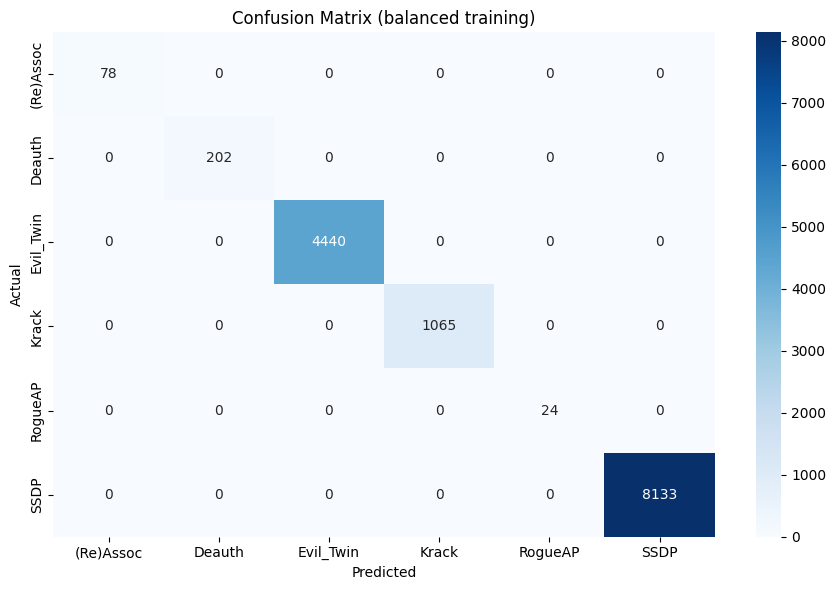

In [ ]:
y_pred = lgbm.predict(X_test_t)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=lgbm.classes_)
plt.figure(figsize=(9,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lgbm.classes_, yticklabels=lgbm.classes_)
plt.title("Confusion Matrix (balanced training)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1s = []

TARGET_PER_CLASS = 15000
MAJORS = {"SSDP": TARGET_PER_CLASS, "Evil_Twin": TARGET_PER_CLASS}

fold = 0
for tr_idx, va_idx in skf.split(X, y):
    fold += 1
    X_tr, X_va = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    # === preprocess like before ===
    X_tr, X_va, num_cols_f, cat_cols_f = coerce_mixed_columns(X_tr, X_va, hex_ok=True, thresh=0.8)

    # sanitize categorical dtypes
    if len(cat_cols_f):
        X_tr[cat_cols_f] = X_tr[cat_cols_f].astype("object")
        X_va[cat_cols_f] = X_va[cat_cols_f].astype("object")
    X_tr = X_tr.replace({pd.NA: np.nan})
    X_va = X_va.replace({pd.NA: np.nan})

    # drop all-NaN columns
    drop_cols = list(set(X_tr.columns[X_tr.isna().all()]) | set(X_va.columns[X_va.isna().all()]))
    if drop_cols:
        X_tr.drop(columns=drop_cols, inplace=True)
        X_va.drop(columns=drop_cols, inplace=True)
        num_cols_f = [c for c in num_cols_f if c not in drop_cols]
        cat_cols_f = [c for c in cat_cols_f if c not in drop_cols]

    # Preprocessor
    num_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    cat_tf = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordenc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])
    prep_f = ColumnTransformer(
        [("num", num_tf, num_cols_f)] + ([("cat", cat_tf, cat_cols_f)] if cat_cols_f else []),
        remainder="drop"
    )

    Xt_tr = prep_f.fit_transform(X_tr)
    Xt_va = prep_f.transform(X_va)

    # === balancing: undersample + SMOTE ===
    rus = RandomUnderSampler(sampling_strategy=MAJORS, random_state=42)
    Xt_tr_under, y_tr_under = rus.fit_resample(Xt_tr, y_tr)

    counts = Counter(y_tr_under)
    smote_plan = {cls: TARGET_PER_CLASS - n for cls, n in counts.items() if n < TARGET_PER_CLASS}
    if smote_plan:
        min_class_size = min(counts[c] for c in smote_plan.keys())
        k_neighbors = max(1, min(5, min_class_size - 1))
        sm = SMOTE(sampling_strategy=smote_plan, k_neighbors=k_neighbors, random_state=42)
        Xt_tr_res, y_tr_res = sm.fit_resample(Xt_tr_under, y_tr_under)
    else:
        Xt_tr_res, y_tr_res = Xt_tr_under, y_tr_under

    # === LightGBM ===
    clf = LGBMClassifier(
        objective="multiclass",
        num_class=len(np.unique(y)),
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=-1,
        min_child_samples=50,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(Xt_tr_res, y_tr_res)

    yhat = clf.predict(Xt_va)
    f1_macro = f1_score(y_va, yhat, average="macro", zero_division=0)
    f1s.append(f1_macro)
    print(f"Fold {fold}: macro-F1 = {f1_macro:.4f}")

print("\n✅ 5-Fold Macro-F1 scores:", np.round(f1s, 4))
print("Mean ± Std:", np.mean(f1s).round(4), "±", np.std(f1s).round(4))


In [ ]:
# Feature names after transform
feat_names = prep.get_feature_names_out()
imp = lgbm.feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": imp}).sort_values("importance", ascending=False)
display(fi.head(15))

# Save artifacts
from pathlib import Path
import joblib, json
art = Path("/content/artifacts"); art.mkdir(exist_ok=True)

joblib.dump(prep, art/"preprocessor.joblib")
joblib.dump(lgbm, art/"lgbm_multiclass_balanced.joblib")
with open(art/"feature_names.json","w") as f: json.dump(list(map(str, feat_names)), f, indent=2)
with open(art/"classes.json","w") as f: json.dump(list(map(str, lgbm.classes_)), f, indent=2)

print("Saved to:", art)


,feature,importance
3,num__frame.time_relative,9954
6,num__radiotap.dbm_antsignal,7957
15,num__wlan.seq,7366
1,num__frame.time_delta,7311
0,num__frame.len,5365
18,num__wlan_radio.signal_dbm,4608
14,num__wlan_radio.duration,3811
7,num__wlan.duration,2460
4,num__radiotap.channel.freq,2154
11,num__wlan.fc.retry,1778


Saved to: /content/artifacts
